# Convolutional Neural Net (CNN) Fraud Classifier

Another Neural Net Architecture that can handle series data are __Convolutional Neural Nets (CNN)__. They are mainly used in image recognition and *vision* problems in general. But might have some use in Fraud detection.

With CNN's the network uses convolutional filters, it slides these filters over the data along an axis. For instance in our Transactional data case, the filter would slide along the time-axis. A filter sees a number of elements (here we see two), depending on the size of the filter. This is often named the __kernel size__. The number of elements it moves is named the __stride__, in this case the stride is one. We move the filter/kernel one position at a time.

For time-series we will use a 1d convolution, the kernel_size is a single number and the 'depth' of the filter is the full 'depth/height' of the series, i.e. it spans the full set of features.

At each position the filter outputs one an only one number; the sum of the element wise multiplication of the filter and the portion of the input it spans. $o= \sum_{i=1}^{ks} \sum_{j=1}^{cc} x_{ij} f_{ij}$, where $ks=kernel size$ and $cc=input channel count$ (i.e. features) or $o = \sum x \bigotimes \ f$.

Therefore having one filter slide over the input gives us and array, a 1D - Tensor. The lenght of that tensor is shorter or equal the series length. $Length = \frac {inputlength - kernelsize + 2 * padding} {stride} + 1$. 

Intuitively we can think of this as an array that shows the 'reaction' of the filter of a certain input area.

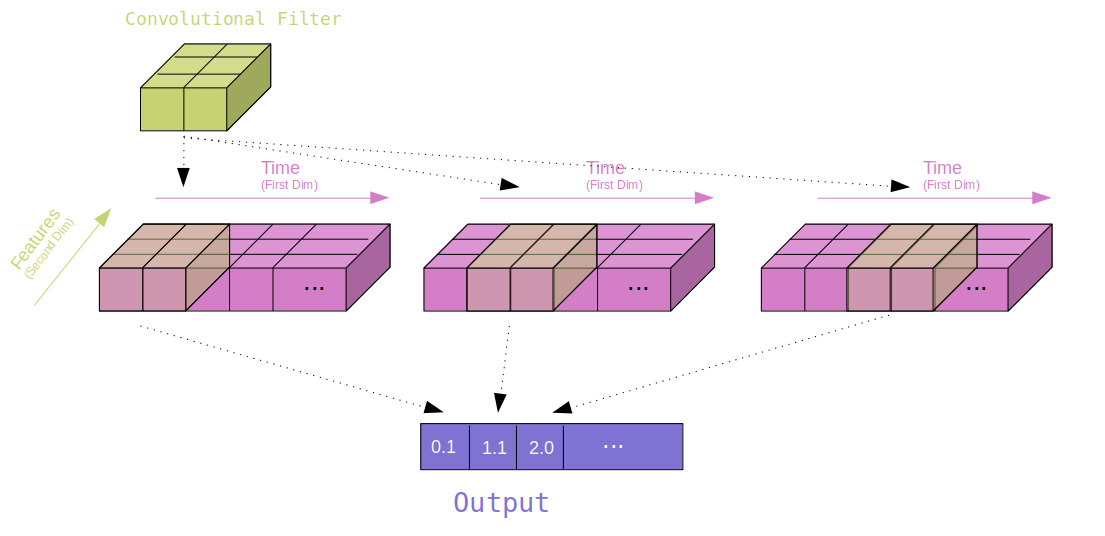

Now, CNN's don't just run one filter over the data. They use multiple filters, the exact amount is defined as '#Filters' or '#Channels'. 

Each filter has an output as described above, each of these arrays has the same length and can be concatenated along the second axis. In the example below five filters then give a seconds dimension size of five.

That gives us a 2-D Tensor where the __width__ depends on the formula specified above and the __depth/height__ depends on the number of features/channels specified in the layer. So we end-up with a new block of data that potentially has a different size. Intuitively we can think of that block as showing how *each* filter reacted to a specified input area. Note that the filters are lined up over a 'reduced' time axis, but the aspect/sequence of time is maintained. All elements along the second axis correspond to the same time portion.

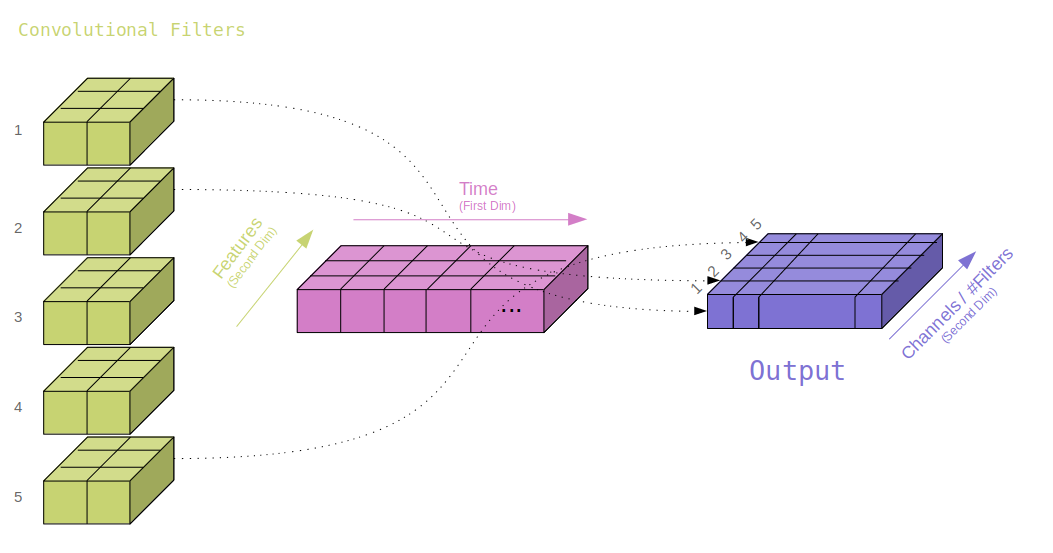

In order to help build some intuition of how these filters/kernels could help detect Fraud, we'll include a small *purely hypothetical* example.

If we think back to the one-hot encoded vectors showing the 'bin' of the amount. And let's say we have split our amounts in 3 bins, then a small amount might be represented as;

$S_{amount} = \begin{bmatrix}0 \\ 0 \\ 1  \end{bmatrix}$

I.e. there is a 1 in the low range, having a 1 in the high range would mean we have a big amount.

$B_{amount} = \begin{bmatrix}1 \\ 0 \\ 0  \end{bmatrix}$

If we put these in a series, where the columns are the time, then we have a small amount followed by a big amount

$I_{sb} = \begin{bmatrix}0 & 1 \\ 0 & 0 \\ 1 & 0  \end{bmatrix}$.

Then if we were to have a filter that looks like so;

$F= \begin{bmatrix}-1 & 1 \\ 0.3 & 0 \\ 1 & 0 \end{bmatrix}$

Our input $I_{sb}$ filtered by $F$. Would give __2__. $(0 * -1) + (1 * 1) + (0 * 0.3) + (0 * 0) + (1 * 1) + (0 * 0)$. A fairly strong reaction.

Reversing the transactions (big followed by small) $I_{bs} = \begin{bmatrix}1 & 0 \\ 0 & 0 \\ 0 & 1  \end{bmatrix}$. Would give a product of __-1__. A negative reation.

Two big transcations $I_{bb} = \begin{bmatrix}1 & 1 \\ 0 & 0 \\ 0 & 0  \end{bmatrix}$. Would give a product of __0__. No reaction whatsoever. 

We can see that these filters react differently to the sequences and thus give the Neural Net the ability to 'detect' patterns in the series. Maybe important to note is the our filter is time-invariant, it can find small payments followed by big ones anywhere in the sequence, whether it's the 9th and 7th or the 5th and 4th... the reaction will be the same.

Clearly it would not be doing this using just the amount, but all of the input features.

Convolutional Nets can __optimize__ the content of the filters to optimally reduce the loss and solve a specific problem. We can see that they theoretically have the ability to come up with a set of filter(s) that can detect certain patterns in the transactional data. The output of the convolutions can then for instance be used to detect various patterns being present in the data.

---
#### Note on the data set 
The data set used here is not particularly complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

## Imports

In [1]:
import torch
import numpy as np
import pandas as pd
import datetime as dt
import gc

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define base feature and read the File
The base features are features found in the input file. They need to be defined after which the file can be read using the `EnginePandasNumpy`. Using the `from_csv` method.

In [3]:
# Change this to read from another location
file = '../../../../data/bs140513_032310.csv'

In [5]:
step = ft.FeatureSource('step', ft.FEATURE_TYPE_INT_16) 
customer = ft.FeatureSource('customer', ft.FEATURE_TYPE_STRING)
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

base_features = ft.TensorDefinition(
    'base', 
    [
        step,
        customer,
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])

amount_binned = ft.FeatureBin('amount_bin', ft.FEATURE_TYPE_INT_16, amount, 30)

def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])

intermediate_features = ft.TensorDefinition(
    'intermediate', 
    [
        customer,
        step,
        age,
        gender,
        merchant,
        category,
        amount_binned,
        fraud
    ])

amount_oh = ft.FeatureOneHot('amount_one_hot', amount_binned)
age_oh = ft.FeatureOneHot('age_one_hot', age)
gender_oh = ft.FeatureOneHot('gender_one_hot', gender)
merchant_oh = ft.FeatureOneHot('merchant_one_hot', merchant)
category_oh = ft.FeatureOneHot('category_one_hot', category)
fraud_label = ft.FeatureLabelBinary('fraud_label', fraud)

learning_features = ft.TensorDefinition(
    'learning', 
    [
        customer,
        date_time,
        age_oh,
        gender_oh,
        merchant_oh,
        category_oh,
        amount_oh
    ])

label = ft.TensorDefinition('label', [fraud_label])

model_features = ft.TensorDefinitionMulti([learning_features, label])

with en.EnginePandasNumpy() as e:
    df = e.from_csv(base_features, file, inference=False)
    df = e.from_df(intermediate_features, df, inference=False)
    ft_df = e.from_df(learning_features, df, inference=False)
    lb_df = e.from_df(label, df, inference=False)
    lb_np = e.to_numpy_list(label, lb_df)
    ser_np = e.to_series_stacked(ft_df, learning_features, key_field=customer, time_field=date_time, length=5)
    data_list = en.NumpyList(ser_np.lists + lb_np.lists)

print(data_list.shapes)
print(data_list.dtype_names)

2021-02-07 12:15:57.199 d373c7.engines.common          INFO     Start Engine...
2021-02-07 12:15:57.200 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2021-02-07 12:15:57.200 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2021-02-07 12:15:57.200 d373c7.engines.panda_numpy     INFO     Building Panda for : base from file ../../../../data/bs140513_032310.csv
2021-02-07 12:15:57.408 d373c7.engines.panda_numpy     INFO     Building Panda for : <base> from DataFrame. Inference mode <False>
2021-02-07 12:15:57.421 d373c7.engines.panda_numpy     INFO     Done creating base. Shape=(594643, 8)
2021-02-07 12:15:57.422 d373c7.engines.panda_numpy     INFO     Building Panda for : <intermediate> from DataFrame. Inference mode <False>
2021-02-07 12:15:57.440 d373c7.engines.panda_numpy     INFO     Done creating intermediate. Shape=(594643, 8)
2021-02-07 12:15:57.441 d373c7.engines.panda_numpy     INFO     Building Panda for : <learning> from DataFrame. Inference mode 

[(594643, 5, 107), (594643,)]
['int8', 'int8']


## Wrangle the data
Time to split the data. For time series data it is very important to keep the order of the data. Below split will start from the end and work it's way to the front of the data. Doing so the training, validation and test data are nicely colocated in time. You almost *never* want to plain shuffle time based data.

> 1. Split out a test-set of size `test_records`. This is used for model testing.
> 2. Split out a validation-set of size `validation_records`. It will be used to monitor overfitting during training
> 3. All the rest is considered training data.

For time-series we'll perform an additional action.
> 1. The series at the beginning of the data set will all be more or less empty as there is no history, that is not so useful during training, ideally we have records with history and complete series, sometimes named 'mature' series. We'll throw away the first couple of entries.

__Important__; please make sure the data is ordered in ascending fashion on a date(time) field. The split function does not order the data, it assumes the data is in the correct order.

In [6]:
test_records = 100000
val_records  = 30000 
maturation   = 30000

train_data, val_data, test_data = data_list.split_time(val_records, test_records) 
train_data = train_data[maturation:]

print(f'Training Data shapes {train_data.shapes}')
print(f'Validation Data shapes {val_data.shapes}')
print(f'Test Data shapes {test_data.shapes}')
del data_list, df, ft_df, lb_df, lb_np, ser_np
gc.collect()
print('Done')

Training Data shapes [(434643, 5, 107), (434643,)]
Validation Data shapes [(30000, 5, 107), (30000,)]
Test Data shapes [(100000, 5, 107), (100000,)]
Done


## Set-up Devices

In [7]:
device, cpu = pt.init_devices()

2021-02-07 12:16:47.699 d373c7.pytorch.common          INFO     Torch Version : 1.7.1+cu110
2021-02-07 12:16:47.751 d373c7.pytorch.common          INFO     GPU found. Using GPU <0>
2021-02-07 12:16:47.751 d373c7.pytorch.common          INFO     Cuda Version  : 11.0


## Build the model
We give it the TensorDefinition of Learning features, then ask it to build a __Convolutioanl NN__ having 2 conv layers, the first has 12 output_channels/features, a *kernel_size* of 2 and *stride* of 1, the second layer has 24 output_channels/features, a *kernel_size* of 2 and *stride* of 1. And we ask the model to add 1 *linear* layer of size 8 after that.

In [8]:
# Setup Pytorch Datasets for the training and validation
batch_size = 128
train_ds = pt.NumpyListDataSetMulti(model_features, train_data)
val_ds = pt.NumpyListDataSetMulti(model_features, val_data)
train_sampler = pt.ClassSamplerMulti(model_features, train_data).over_sampler()

# Wrap them in a Pytorch Dataloader
train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2, sampler=train_sampler)
val_dl = val_ds.data_loader(cpu, batch_size, num_workers=2)

# Create a Model

m = pm.GeneratedClassifier(model_features, convolutional_layers=[(12, 2, 1), (24, 2, 1)], linear_layers=[8])

print(m)

GeneratedClassifier(
  Number of parameters : 4693
  (streams): ModuleList(
    (0): Sequential(
      (learning): TensorDefinitionHead(lcs=['Binary'])
      (Convolutional): ConvolutionalBody1d(
        (conv_layers): Sequential(
          (conv_01): Conv1d(107, 12, kernel_size=(2,), stride=(1,))
          (relu_01): ReLU(inplace=True)
          (conv_02): Conv1d(12, 24, kernel_size=(2,), stride=(1,))
          (relu_02): ReLU(inplace=True)
          (norm_02): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (tail): TailBinary(
    (layers): Sequential(
      (tail_lin_01): Linear(in_features=179, out_features=8, bias=True)
      (tail_act_01): ReLU()
      (tail_dropout_01): Dropout(p=0.1, inplace=False)
      (tail_batch_norm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (tail_binary): Linear(in_features=8, out_features=1, bias=Tru

Grapically that model looks like below;

Overall this is very similar to first. the Recurrent example. But here we have a `Convolutional` layer instead of a recurrent layer. 

The convolutional layer will reduce the output in 2 layers. First it will be reduced to a (12,4) 2-D tensor. (12 for the output channels and 4 as a result the the formula in the intro to calculate the new length). The second later will further reduce that to a __(24,3) 2-D tensor__. (12 for the output channels and 3 as a result the the formula in the intro to calculate the new length).

the (24,3) 2-D tensor is __flattened__ to a (72) 1-D Tensor, we add the entire last payment to that so end-up with a (179) 1-D Tensor, which follow the path down to linear layers etc...

*(Some layers have been omitted for simplicity)*

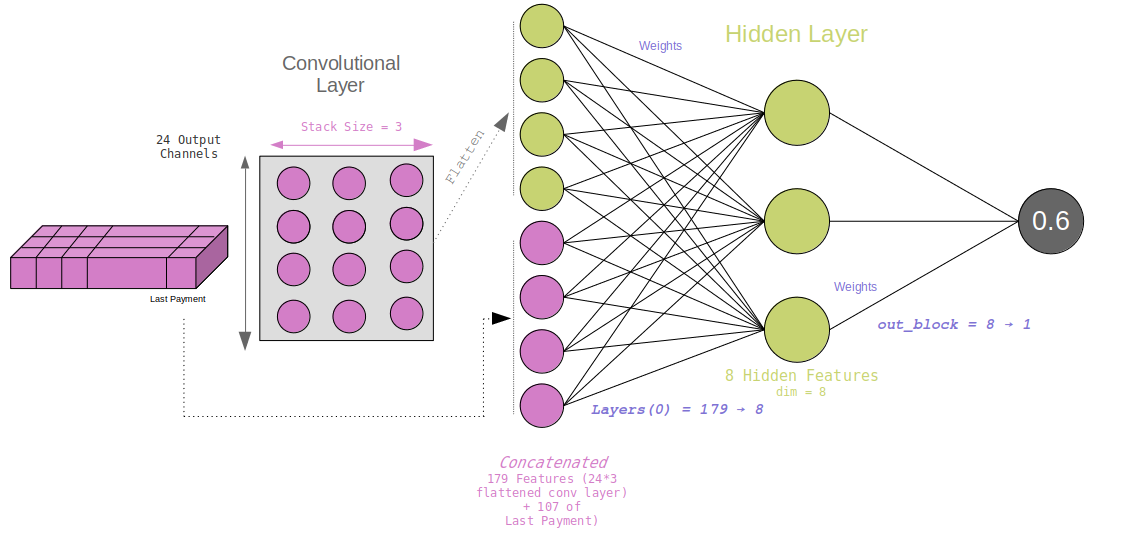

# Start Training
### First find a decent Learning Rate. 
> Create a trainer and run the find_lr function and plot. This functions iterates over the batches gradually increasing the learning rate from a minimum to a maximum learning rate.

2021-02-07 12:18:10.777 d373c7.pytorch.training        INFO     Saving model under ./temp_model.pt
Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 252.83it/s]
2021-02-07 12:18:13.492 d373c7.pytorch.training        INFO     Restoring model from ./temp_model.pt


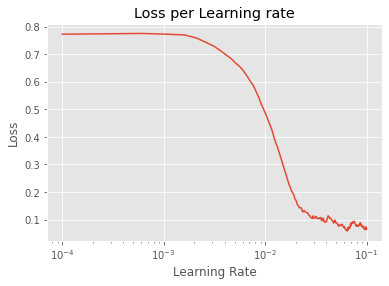

In [9]:
t = pt.Trainer(m, device, train_dl, val_dl)
r = t.find_lr(1e-4, 1e-1, 200)
pl.TrainPlot().plot_lr(r)

## Start Training and plot the results
> We train for __10 epochs__ and __learning rate 5e-3__. That means we run over the total training data set a total of 10 times/epochs where the model learns, after each epoch we use the trained model and perform a test run on the validation set.

Epoch 010/010: 100%|██████████| 3631/3631 [00:12<00:00, 301.38it/s, train_loss=0.0254, train_acc=0.992, val_loss=0.0201, val_acc=0.994]


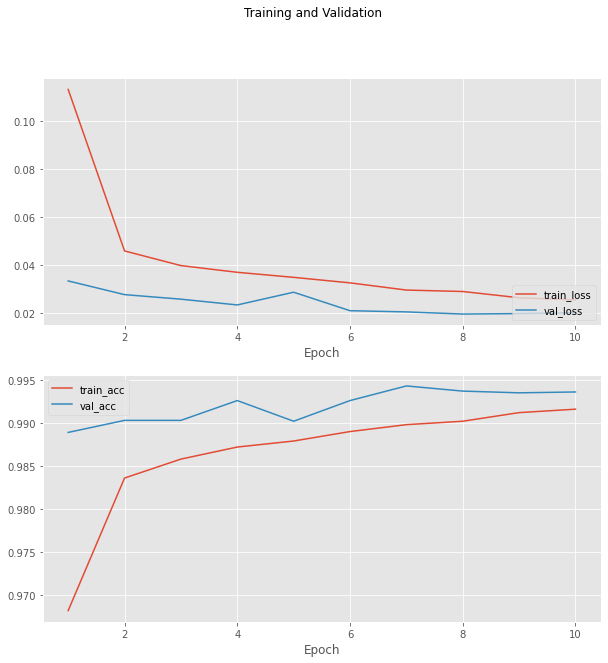

In [10]:
t = pt.Trainer(m, device, train_dl, val_dl)
h = t.train_one_cycle(10, 5e-3)
pl.TrainPlot().plot_history(h, fig_size=(10,10))

## Test the model on the test data

> Test the model on the test set, it is data that was not seen during training and allows us to validate model results.

Testing in 782 steps: 100%|██████████| 782/782 [00:00<00:00, 1176.26it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     98926
         1.0       0.69      0.95      0.80      1074

    accuracy                           0.99    100000
   macro avg       0.84      0.97      0.90    100000
weighted avg       1.00      0.99      1.00    100000


auc score : 0.9942
ap score  : 0.9432
-----------------------------------------------------


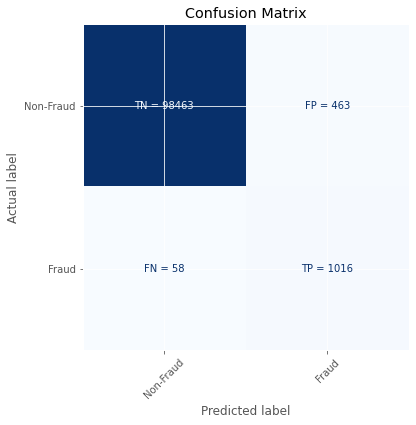

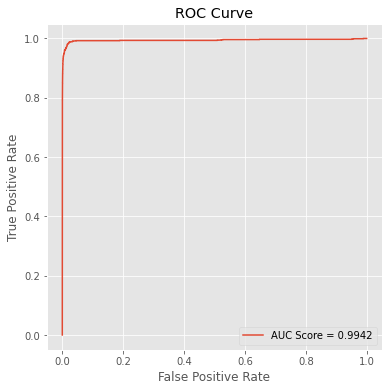

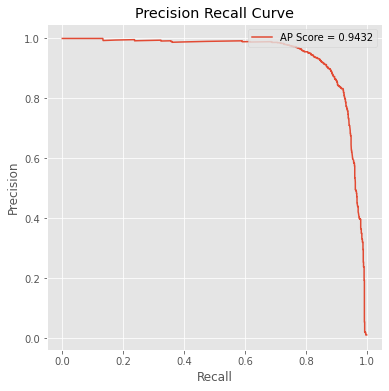

In [13]:
test_ds = pt.NumpyListDataSetMulti(model_features, test_data)
test_dl = test_ds.data_loader(cpu, 128, num_workers=2)

ts = pt.Tester(m, device, test_dl)
pr = ts.test_plot()
tp = pl.TestPlot()
tp.print_classification_report(pr)
tp.plot_confusion_matrix(pr, fig_size=(6,6))
tp.plot_roc_curve(pr, fig_size=(6,6))
tp.plot_precision_recall_curve(pr, fig_size=(6,6))